In [1]:
import os
import math

import tarfile

import pandas as pd
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

from random import shuffle

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms, utils, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

print("GPU available: {}".format(torch.cuda.is_available()))

GPU available: True


# 实验五  深度学习
实验目的
+ 练习使用基本的CNN框架分析图像数据。

使用的数据集：表情识别数据集

## 一、数据获取
Modal Arts从OBS中获取数据，文件数不宜太多。这里我选择把数据集打包为tar文件上传OBS，同步目录后进行解压。

首先，定义一些路径：

In [2]:
tar_file = './datasets/expression-recognition.tar'
data_root = './cache/ext_data'
image_path = data_root+'/data'
label_file = data_root+'/data_label.csv'

定义解压的工具函数

In [3]:
def untar(tar_file, ext_path):
    if os.path.exists(ext_path):
        os.removedirs(ext_path)
    os.makedirs(ext_path)
    t = tarfile.open(tar_file)
    t.extractall(path=ext_path)

In [4]:
untar(tar_file, data_root)

查看一下数据集

In [5]:
def show_img(idx, df):
    if idx < 0 or idx > 19107:
        print("idx error")
    with Image.open(os.path.join(image_path, df.loc[idx].pic_name)) as img:
        plt.imshow(img)
        print("label : " + str(df.loc[idx].label))

In [6]:
df = pd.read_csv(label_file)

label : 4


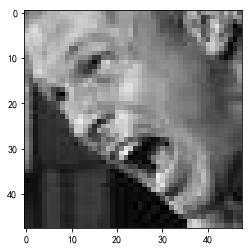

In [7]:
show_img(1, df)

### 数据集分割
由于各种类别的数据数量十分不平衡，我选择手动分割数据集。

准备工作：统计各label的数目

In [8]:
n_labels = len(df.drop_duplicates(['label']))
bucket = [[] for i in range(n_labels)] # 统计各label数量的容器
label_nums = np.zeros(n_labels).astype(int)
for row in df.itertuples():
    bucket[row.label].append(row.pic_name)
    label_nums[row.label] += 1
label_nums = np.array(label_nums)
print("total size is ", label_nums)

total size is  [6644 6160 2422 2070 1466   45  301]


使用5%作为测试集、5%作为验证集、90%作为训练集

In [9]:
test_size = dev_size = (label_nums * 0.05).astype(int)
train_size = label_nums - test_size - dev_size

print("train size is ", train_size)
print("dev   size is ", dev_size)
print("test  size is ", test_size)

train size is  [5980 5544 2180 1864 1320   41  271]
dev   size is  [332 308 121 103  73   2  15]
test  size is  [332 308 121 103  73   2  15]


洗牌，重新包装成三个df

In [10]:
for l in bucket:
    shuffle(l)

# merge files of each label
train_list = [[],[]]
dev_list = [[],[]]
test_list = [[],[]]
for i in range(n_labels):
    train_list[0] += bucket[i][:train_size[i]]
    dev_list[0] += bucket[i][train_size[i]:train_size[i]+dev_size[i]]
    test_list[0] += bucket[i][train_size[i]+dev_size[i]:train_size[i]+dev_size[i]+test_size[i]]
    
    train_list[1] += [i for ii in range(train_size[i])]
    test_list[1] += [i for ii in range(test_size[i])]
    dev_list[1] += [i for ii in range(dev_size[i])]
    
assert len(train_list[0]) == len(train_list[1]) == np.sum(train_size)
assert len(test_list[0]) == len(test_list[1]) == np.sum(test_size)
assert len(dev_list[0]) == len(dev_list[1]) == np.sum(dev_size)

# turn list into ndarray
train_array = np.array(train_list).T
dev_array = np.array(dev_list).T
test_array = np.array(test_list).T

# crate dataframs
train_df = pd.DataFrame(train_array, columns=['pic_name','label'])
dev_df = pd.DataFrame(dev_array, columns=['pic_name','label'])
test_df = pd.DataFrame(test_array, columns=['pic_name','label'])

train_df.label = train_df.label.astype('int')
test_df.label = test_df.label.astype('int')
dev_df.label = dev_df.label.astype('int')

## 二、编写Dataset
首先继承Dataset抽象类，重写方法
1. 在`__init__`中，读取label文件
2. 在`__len__`中返回样本数
3. 在`__getitem__`中读取图片，返回{'image','label'}的字典
4. 如果需要进行transform，在`__getitem__`最后完成

我使用的Dataset同时包含image和label。

In [11]:
class ERDataset(Dataset):
    """expression-recognition dataset"""
    def __init__(self, df, image_path, transform=None):
        self.df = df
        self.image_path = image_path
        self.transform = transform
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        img_file = os.path.join(self.image_path,
                                self.df.iloc[idx].pic_name)
        image = Image.open(img_file)
        label = self.df.iloc[idx].label
        sample = image, label
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

实例化类并尝试进行迭代查看几张数据

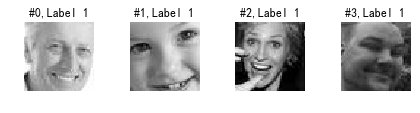

In [12]:
dataset = ERDataset(train_df, image_path)
fig = plt.figure()

start_idx = 6000
for i in range(4):
    image, label = dataset[i + start_idx]
    ax = plt.subplot(1,4,i+1)
    plt.tight_layout()
    ax.set_title("#{},Label {}".format(i,label))
    ax.axis('off')
    plt.imshow(image, cmap="gray")

## 三、数据预处理
原生图像没有办法直接放到模型中去跑，需要变换。同时，通过变换可以达到数据增强的效果。

准备使用的变换有：
1. Rescale：缩放图片
2. RandomCrop：随机截取
3. Mirror：左右镜像
4. ToTensor：将Numpy数组变为Torch张量

首先实现这些变换类：

In [13]:
class Rescale(object):
    """缩放图片

    Args:
        output_size (int): 输出图片的长和宽
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample

        output_size = self.output_size
        image = transforms.Resize((output_size, output_size))(image)

        return image, label

In [14]:
class RandomCrop(object):
    """随机截取

    Args:
        output_size (int): 截取的图片大小
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample

        image = transforms.RandomCrop(self.output_size)(image)

        return image, label

In [15]:
class Flipper(object):
    """镜像翻转"""
    def __call__(self, sample):
        image, label = sample
        return transforms.RandomHorizontalFlip(1)(image), label

In [16]:
class ToTensor(object):
    """把ndarray变成torch tensor"""

    def __call__(self, sample):
        image, label = sample

        return transforms.ToTensor()(image), torch.full((1,),label)

In [17]:
class Normalize(object):
    """归一化

    Args:
        mean, std (tuple): 均值，标准差
    """

    def __init__(self, mean, std):
        assert isinstance(mean, (tuple))
        assert isinstance(std, (tuple))
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        image, label = sample

        image = transforms.Normalize(self.mean, self.std)(image)

        return image, label

随意举个例子，尝试下用上述变换进行组合实例化Dataset

In [18]:
transformed_dataset = ERDataset(train_df, image_path,
                                transform=transforms.Compose([
                                    Rescale(48),
                                    RandomCrop(30),
                                    Flipper(),
                                    ToTensor(),
                                    Normalize((0.1307,), (0.3081,))
                                ]))
for i in range(3):
    image, label = transformed_dataset[i]
    print("#{}".format(i), "shape: {}".format(image.shape),
          "type: {}".format(type(image)), end='\n')

#0 shape: torch.Size([1, 30, 30]) type: <class 'torch.Tensor'>
#1 shape: torch.Size([1, 30, 30]) type: <class 'torch.Tensor'>
#2 shape: torch.Size([1, 30, 30]) type: <class 'torch.Tensor'>


## 四、训练模型
首先定义用到的超参数：

In [19]:
BATCH_SIZE = 128 # minibatch的大小
EPOCHS = 40      # 迭代次数
NUM_WORKERS = 2  # CPU工作线程数
TEST_SIZE = 250  # 测试集大小
DEV_SIZE = 250   # 验证集大小
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 4.1 准备数据
实例化 Dataset 和 Data Loader

In [20]:
# 实例化训练数据集并预处理
train_dataset = ERDataset(train_df, image_path,
                    transform=transforms.Compose([
                        ToTensor(),
                        Normalize((0.1307,), (0.3081,))
                    ]))

# 实例化验证数据集并预处理
dev_dataset = ERDataset(dev_df, image_path,
                    transform=transforms.Compose([
                        ToTensor(),
                        Normalize((0.1307,), (0.3081,))
                    ]))

# 实例化测试数据集并预处理
test_dataset = ERDataset(test_df, image_path,
                    transform=transforms.Compose([
                        ToTensor(),
                        Normalize((0.1307,), (0.3081,))
                    ]))

# 分别实例化DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, 
                        num_workers=NUM_WORKERS, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS, shuffle=True)

### 4.2 建立模型
先建立一个简单的CNN模型

In [41]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # input size = batch * 1 * 48 * 48
        
        self.conv1 = nn.Sequential(
                        nn.Conv2d(1,10,3),
                        nn.BatchNorm2d(10)
                    ) 
        self.conv2 = nn.Sequential(
                        nn.Conv2d(10,20,3),
                        nn.BatchNorm2d(20)
                    )
        self.conv3 = nn.Sequential(
                        nn.Conv2d(20,40,3),
                        nn.BatchNorm2d(40)
                    )
        self.conv4 = nn.Sequential(
                        nn.Conv2d(40,80,4),
                        nn.BatchNorm2d(80),
                        nn.Dropout(0.5)
                    )
        self.conv5 = nn.Sequential(
                        nn.Conv2d(80,160,4),
                        nn.BatchNorm2d(160),
                        nn.Dropout(0.5)
                    )
        self.conv6 = nn.Sequential(
                        nn.Conv2d(160,320,3),
                        nn.BatchNorm2d(320),
                        nn.Dropout(0.35)
                    )

        self.fc1 = nn.Sequential(
                        nn.Linear(320*2*2,512),
                        nn.BatchNorm1d(512)
                    )
        self.fc2 = nn.Sequential(
                        nn.Linear(512,256),
                        nn.BatchNorm1d(256)
                    )
        self.fc3 = nn.Linear(256,7)
    
    def forward(self, x):
        batch_size = x.size(0)
        
        # Conv layer1
        out = self.conv1(x)            # 10*46*46
        out = F.relu(out)
        
        # Conv layer2
        out = self.conv2(out)          # 20*44*44
        out = F.relu(out)
        
        # Conv layer3
        out = self.conv3(out)          # 40*42*42
        out = F.relu(out)
        out = F.max_pool2d(out, 2, 2)  # 40*21*21
        
        # Conv layer4
        out = self.conv4(out)          # 80*18*18
        out = F.relu(out)
        out = F.max_pool2d(out,2,2)    # 80*9*9
        
        # Conv layer5
        out = self.conv5(out)          # 160*6*6
        out = F.relu(out)
        
        # Conv layer6
        out = self.conv6(out)          # 320*4*4
        out = F.relu(out)
        out = F.avg_pool2d(out, 2, 2)  # 320*2*2
        
        # Flatten
        out = out.view(batch_size, -1)
        
        # FC layer1
        out = self.fc1(out)            # 512*1
        out = F.relu(out)
        
        # FC layer2
        out = self.fc2(out)            # 256*1
        out = F.relu(out)
        
        # FC layer3
        out = self.fc3(out)            # 7*1
        out = F.log_softmax(out, dim=1)
        
        return out

实例化一个网络，移动到GPU，选择优化器

In [42]:
model = ConvNet().to(DEVICE)
optimizer = optim.Adam(model.parameters())

定义训练函数，损失函数选择`nll_loss`

In [43]:
 def train(model, device, loader, optimizer, epoch):
    model.train()
    print("\nEpoch {}:".format(epoch))
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.view(target.size(0)).long().to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

定义测试函数

In [44]:
def test(model, device, loader, name):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.view(target.size(0)).long().to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            
        test_loss /= len(loader.dataset)
            
        print('On {} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            name, test_loss, correct, len(loader.dataset),
            100. * correct / len(loader.dataset)))

### 4.3 开始训练

In [45]:
for epoch in range(EPOCHS):
    train(model, DEVICE, train_loader, optimizer, epoch)
    if (epoch+1) % 5 == 0:
        test(model, DEVICE, train_loader, 'Train')
    test(model, DEVICE, dev_loader, 'Dev')  


Epoch 0:
On Dev set: Average loss: 0.9120, Accuracy: 643/954 (67%)

Epoch 1:
On Dev set: Average loss: 0.8028, Accuracy: 675/954 (71%)

Epoch 2:
On Dev set: Average loss: 0.8363, Accuracy: 683/954 (72%)

Epoch 3:
On Dev set: Average loss: 0.8033, Accuracy: 673/954 (71%)

Epoch 4:
On Train set: Average loss: 0.5449, Accuracy: 13628/17200 (79%)
On Dev set: Average loss: 0.6781, Accuracy: 727/954 (76%)

Epoch 5:
On Dev set: Average loss: 0.7594, Accuracy: 691/954 (72%)

Epoch 6:
On Dev set: Average loss: 0.7586, Accuracy: 689/954 (72%)

Epoch 7:
On Dev set: Average loss: 0.6678, Accuracy: 735/954 (77%)

Epoch 8:
On Dev set: Average loss: 0.9256, Accuracy: 666/954 (70%)

Epoch 9:
On Train set: Average loss: 0.3935, Accuracy: 14604/17200 (85%)
On Dev set: Average loss: 0.6333, Accuracy: 745/954 (78%)

Epoch 10:
On Dev set: Average loss: 0.7881, Accuracy: 705/954 (74%)

Epoch 11:
On Dev set: Average loss: 0.6910, Accuracy: 745/954 (78%)

Epoch 12:
On Dev set: Average loss: 0.6677, Accuracy:

经过多次调整网络结构，达到的最好准确率如上。使用Google net可以稳定达到85%的正确率，接下来如何更好地进行数据预处理和调整网络结构是努力方向。